# **Infer `Cellmask` and `Nucleus`**

***Prior to this notebook, you should have already run through [1.0_image_setup](1.0_image_setup.ipynb).***

### ➡️ **Input:**
In this workflow, a single or multi-channel confocal microscopy image of fluorescently tagged organelles will be used to "infer" (or segment) the cell and nucleus masks. The following setup is recommended for this pipeline:

| **Imaging Requirements**|[**Masks Workflow (A)**](./1.1a_infer_masks_from-composite_single_cell.ipynb)|
| :------------------------------------- |  :------:  |
| Nuclei Marker                          |      ✘     |
| Cell Membrane Marker                   |      ✘     |
| Cytoplasmic Organelles                 |      ✔     |
| Number of cells per image              |   Single   |
| Applicable with sample data         |  Neuron_1   |

*If your images are not compatible with this setup, consider the other 1.1_Masks Workflows available:*

| **Imaging Requirements**|[**Masks Workflow**](./1.1_infer_masks_from-composite_with_nuc.ipynb)|[**Masks Workflow (B)**](./1.1b_infer_masks_from-composite_multiple-cells.ipynb)|[**Masks Workflow (C)**](./1.1c_infer_masks_from-composite_neuron_with_pm.ipynb)|[**Masks Workflow (D)**](./1.1d_infer_masks_from-composite_ipsc.ipynb)|
| :------------------------------------- |  :------:  |  :------:  |  :------:  |  :------:  |
| Nuclei Marker                          |     ✔     |     ✘     |     ✔     |     ✔     |
| Cell Membrane Marker                   |     ✘     |     ✘     |     ✔     |     ✔     |
| Cytoplasmic Organelles                 |     ✔     |     ✔     |     ✔     |     ✔     |
| Number of cells per image              |  Single or Multiple  |  Single or Multiple |  Single or Multiple |  Single or Multiple |
| Applicable with sample data         |  ✘  |  Astrocyte | Neuron_2| IPSC |

### **Included in this Notebook:**
1. **Infer *cytoplasm*** - Segment the ***cytoplasm*** from a composite image of multiple organelle markers combined. The ***cell*** and ***nucleus*** masks will be derived from this image.
    
    *The combination of organelle markers used to create the composite image for the cytoplasm segmentation is based on the assumption that the organelle labels used will "fill up" the entire cytoplasm (not including the nucleus). This is NOT the most accurate method to determine the cell area, but is required in the case where membrane and nuclei markers can not be used or are not included. It is important to consider the specifics of your system as the cell type and labeling method may differ from the example used to optimize this workflow.*

2. **Infer *nucleus*** - Segment the ***nucleus*** from an exclusive or (XOR) of the ***cytoplasm*** mask and a hole-filled version of the ***cytoplasm*** mask.
3. **Infer *cellmask***
Segment the ***cellmask*** by combining the ***nucleus*** and ***cytoplasm*** masks.
-----

### 👣 **Summary of steps**  

➡️ **EXTRACTION**
- **`STEP 1`** - Create composite image

    - determine weight to apply to each channel of the intensity image (w# = user input)
    - rescale summed image intensities (rescale = user input)

**PRE-PROCESSING**
- **`STEP 2`** - Rescale and smooth image

    - rescale intensity of composite image (min=0, max=1)
    - median filter (median size = user input)
    - gaussian filter (sigma = user input)
    
- **`STEP 3`** - Log transform + Scharr edge detection

    - perform a log transformation on the image
    - apply Scharr edge detection filter
    - combine log image and Scharr edge filtered intensity image
 
**CORE PROCESSING**
- **`STEP 4`** - Global + local thresholding (AICSSeg – MO) of cytoplasm

    - apply MO thresholding method from the Allen Cell [aicssegmentation](https://github.com/AllenCell/aics-segmentation) package (threshold options = user input)

**POST-PROCESSING**
- **`STEP 5`** - Remove small holes and objects

    - fill holes (hole size = user input)
    - remove small objects (object size = user input)
    - filter method = (method = user input)

**POST-POST-PROCESSING**
- **`STEP 6`** - Create nucleus mask from cytoplasm mask

    - binary dilation
    - fill nucleus (hole size = user input)
    - binary erosion
    - logical **XOR** of the cytoplasm and the filled in cytoplasm resulting in the nucleus and any artifacts from dilation/erosion
    - remove small objects (object size = user input)


- **`STEP 7`** - Create cellmask from cytoplasm and nucleus mask

    - logical **OR** of the nucleus and cytoplasm
    - fill small holes (hole size = user input)
    - remove small objects (object size = user input)

**OUTPUT** ➡️ 
- **`STEP 8`** - Stack masks

    - Stack masks in order of nucleus, cellmask and cytoplasm mask

---------------------
## **IMPORTS AND LOAD IMAGE**
Details about the functions included in this subsection are outlined in the [`1.0_image_setup`](1.0_image_setup.ipynb) notebook. Please visit that notebook first if you are confused about any of the code included here.

#### &#x1F3C3; **Run code; no user input required**

In [1]:
from pathlib import Path
import os

import numpy as np
import pandas as pd
import napari
from napari.utils.notebook_display import nbscreenshot

from skimage.morphology import binary_dilation, binary_erosion

from infer_subc.core.file_io import (read_czi_image, 
                                     export_inferred_organelle,
                                     list_image_files,
                                     sample_input)
from infer_subc.core.img import *
from infer_subc.organelles import non_linear_cellmask_transform

%load_ext autoreload
%autoreload 2

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following information about your data: `im_type`, `data_root_path`, `in_data_path`, and `out_data_path`.

In [2]:
### USER INPUT REQUIRED ###
# If using the sample data, set cell_type to "neuron_1":
# If not using the sample data, set cell_type to None
sample_data_type = "neuron_1"

# If you are not using the sample data, please edit "USER SPECIFIED" as necessary.
## Define the path to the directory that contains the input image folder.
data_root_path = Path("USER SPECIFIED")

# Specify the file type of your raw data that will be analyzed. Ex) ".czi" or ".tiff"
im_type = "USER SPECIFIED"

## Specify which subfolder that contains the input data and the input data file extension
in_data_path = data_root_path / "USER SPECIFIED"

## Specify the output folder to save the segmentation outputs if.
## If its not already created, the code below will creat it for you
out_data_path = data_root_path / "USER SPECIFIED"

#### &#x1F3C3; **Run code; no user input required**

In [ ]:
# If sample_data_type is set "neuron_1", then the sample data is used and the directories are set
if sample_data_type != None:
    data_root_path, im_type, in_data_path, out_data_path = sample_input(sample_data_type)

# list files in the input folder
img_file_list = list_image_files(in_data_path,im_type)
pd.set_option('display.max_colwidth', None)
pd.DataFrame({"Image Name":img_file_list})

#### &#x1F6D1; &#x270D; **User Input Required:**

Use the list above to specify which image you wish to analyze based on its index: `test_img_n`

In [4]:
#### USER INPUT REQUIRED ###
test_img_n = 0

#### &#x1F3C3; **Run code; no user input required**

In [5]:
# load image and metadata
test_img_name = img_file_list[test_img_n]
img_data,meta_dict = read_czi_image(test_img_name)

# metadata
channel_names = meta_dict['name']
meta = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']
file_path = meta_dict['file_name']
print("Metadata information")
print(f"File path: {file_path}")
for i in list(range(len(channel_names))):
    print(f"Channel {i} name: {channel_names[i]}")
print(f"Scale (ZYX): {scale}")
print(f"Channel axis: {channel_axis}")

# open viewer and add images
viewer = napari.Viewer()
for i in list(range(len(channel_names))):
    viewer.add_image(img_data[i],
                     scale=scale,
                     name=f"Channel {i}")
viewer.grid.enabled = True
viewer.reset_view()
print("\nProceed to Napari window to view your selected image.")

Metadata information
File path: c:\Users\redre\Documents\CohenLab\scohen_lab_repo\infer-subc\sample_data\example_neuron_1\raw\20230727_C2-121_conditioned_well 4_cell 1_untreated_Linear unmixing_0_cmle.ome.tiff
Channel 0 name: 20230727_C2-121_conditioned_well 4_cell 1_untreated_Linear unmixing_0_cmle.ome :: Channel:0
Channel 1 name: 20230727_C2-121_conditioned_well 4_cell 1_untreated_Linear unmixing_0_cmle.ome :: Channel:1
Channel 2 name: 20230727_C2-121_conditioned_well 4_cell 1_untreated_Linear unmixing_0_cmle.ome :: Channel:2
Channel 3 name: 20230727_C2-121_conditioned_well 4_cell 1_untreated_Linear unmixing_0_cmle.ome :: Channel:3
Channel 4 name: 20230727_C2-121_conditioned_well 4_cell 1_untreated_Linear unmixing_0_cmle.ome :: Channel:4
Channel 5 name: 20230727_C2-121_conditioned_well 4_cell 1_untreated_Linear unmixing_0_cmle.ome :: Channel:5
Scale (ZYX): (0.410594, 0.079947, 0.079947)
Channel axis: 0

Proceed to Napari window to view your selected image.


-----

## **EXTRACTION**

### **`STEP 1` - Create composite image**

&#x1F453; **FYI:** This code block creates a composite image of the organelle channels. The intensity of each channel is combined with specified weights. The resulting composite will be used to segment the cytoplasm area. 

*Hint: combine organelles in a way that produces a relatively even intensity throughout the cell.* 

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following values:
- `w0`: the weight of channel 0 (the first channel); a value of 0 will exclude this channel from the compostite; large values will cause this channel to be more prominent in the final composite image
- `w1`: the weight of channel 1
- `w2`: the weight of channel 2
- `w3`: the weight of channel 3
- `w4`: the weight of channel 4
- `w5`: the weight of channel 5
- `w6`: the weight of channel 6
- `w7`: the weight of channel 7
- `w8`: the weight of channel 8
- `w9`: the weight of channel 9
- `rescale`: "True" rescales the image so that the pixel/voxel with the highest intensity is set to 1 and the one with the lowest intensity is set to 0; "False" leaves the combined intensity values as is after the composite is made

In [6]:
#### USER INPUT REQUIRED ###
w0 = 1
w1 = 4
w2 = 1
w3 = 1
w4 = 0
w5 = 2
w6 = 0
w7 = 0
w8 = 0
w9 = 0
cyto_rescale = True

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block creates the composite and optionally rescales the image based on the settings above. The image is then added to Napari as a new layer for visual comparison to the input image. 

Use the Napari viewer to iteratively adjust the weights selected above.

In [7]:
# make aggregate and optionally rescale
struct_img_raw = make_aggregate(img_data,
                                weight_ch0= w0,
                                weight_ch1= w1,
                                weight_ch2= w2,
                                weight_ch3= w3,
                                weight_ch4= w4,
                                weight_ch5= w5,
                                weight_ch6= w6,
                                weight_ch7= w7,
                                weight_ch8= w8,
                                weight_ch9= w9,
                                rescale = cyto_rescale)

# adding image to Napari as a new layer
viewer.layers.clear()
viewer.grid.enabled = False
viewer.reset_view()
viewer.add_image(img_data, scale=scale)
viewer.add_image(struct_img_raw, scale=scale, name="1-Cyto: Create composite")

<Image layer '1-Cyto: Create composite' at 0x27a37a494b0>

-----
## **PRE-PROCESSING**

### **`STEP 2` - Rescale and smooth image**

&#x1F453; **FYI:** This code block rescales the image so that the pixel/voxel with the highest intensity is set to 1 and the one with the lowest intensity is set to 0. The image is then *optionally* smoothed using a Gaussian and/or median filter. 

<mark> Include more information on the Gaussian and median filtering methods here </mark>

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the amount of filter to use for each method. Higher values indicate more smoothing:
- `med_filter_size`: the size of the median filter to apply; if 0 is used, no filter will be applied
- `gaussian_smoothing_sigma`: the sigma to apply in the Gaussian filtering step; if 0 is used, no filter will be applied

In [8]:
#### USER INPUT REQUIRED ###
cyto_med_filter_size = 0
cyto_gaussian_smoothing_sigma = 0

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block rescales the image and applies the specified median and Gaussian filters. The image is then added to Napari as a new layer for visual comparison to the input image. 

Use the Napari viewer to iteratively adjust the smoothing settings selected above.

In [9]:
# rescaling and smoothing input image
structure_img_smooth = scale_and_smooth(struct_img_raw,
                                        median_size = cyto_med_filter_size, 
                                        gauss_sigma = cyto_gaussian_smoothing_sigma)


# adding image to Napari as a new layer
viewer.add_image(structure_img_smooth, scale=scale, name="2-Cyto: Rescale and Smooth")

<Image layer '2-Cyto: Rescale and Smooth' at 0x27a3b493520>

### **`STEP 3` - Log transform + Scharr edge detection**

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block applies a log transform and the [Scharr](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.scharr) edge detection filter.

Use the Napari viewer to iteratively adjust the filter settings as needed.

*Hint: it may be helpful to readjust the composite and smoothing settings to improve the outcome of this step.*

In [10]:
# log scale the image, apply the scharr edge detection filter to logged image, add the two images together
composite_cytomask = non_linear_cellmask_transform(structure_img_smooth)

# adding image to Napari as a new layer
viewer.add_image(composite_cytomask, scale=scale, name="3-Cyto: Log Scharr edge detectiong")

<Image layer '3-Cyto: Log Scharr edge detectiong' at 0x27a43c927a0>

-----
## **CORE-PROCESSING**

### **`STEP 4` - Global + local thresholding (AICSSeg – MO)**

&#x1F453; **FYI:** This code block creates a semantic segmentation of the cytoplasmic area. `Semantic segmentation` is the process of deciding whether a pixel/voxel should be included in an object (labeled with a value of 1) or should be considered as part of the background (labeled with a value of 0). A semantic segmentation does not discern individual objects from one another.

The masked_object_filter utilizes the 'MO' filter from the [`aics-segmentation`](https://github.com/AllenCell/aics-segmentation) package. AICS documentation states: "The algorithm is a hybrid thresholding method combining two levels of thresholds. The steps are: [1] a global threshold is calculated, [2] extract each individual connected componet after applying the global threshold, [3] remove small objects, [4] within each remaining object, a local Otsu threshold is calculated and applied with an optional local threshold adjustment ratio (to make the segmentation more and less conservative). An extra check can be used in step [4], which requires the local Otsu threshold larger than 1/3 of global Otsu threhsold and otherwise this connected component is discarded."

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following values:
- `thresh_method`: the global thresholding method; options include 'tri'/'triangle, 'med'/'median' or 'ave'/'ave_tri_med'. Triangle implements the [skimage.filters.threshold_triangle](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.threshold_triangle) method, median utilizes the 50th percentile of the intensities, and ave uses the average of the two methods to calculate the lower bound of the global threshold.
- `cell_wise_min_area`: the minimum expected size of your object; smaller objects will be removed prior to local thresholding
- `thresh_adj`: adjustment to make to the local threshold; larger values make the segmentation more stringent (less area included)

In [11]:
#### USER INPUT REQUIRED ###
cyto_thresh_method = 'ave'
cyto_cutoff_size =  50
cyto_thresh_adj = 0.05

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block executes the MO filter using the settings above.

Use the Napari viewer to iteratively adjust the filter settings as needed.

In [12]:
# threshold the composite image after log/edge detection using the MO filter function from aicssegmentation - this applies a global threshold, then a local threshold to produce a semantic segmentation
bw = masked_object_thresh(composite_cytomask, 
                          global_method=cyto_thresh_method, 
                          cutoff_size=cyto_cutoff_size, 
                          local_adjust=cyto_thresh_adj)

# adding image to Napari as a new layer
viewer.add_image(bw, scale=scale, name="4-Cyto: MO filter", opacity=0.3, colormap="cyan", blending='additive')

<Image layer '4-Cyto: MO filter' at 0x27a41f50ac0>

-----
## **POST-PROCESSING**

### **`STEP 5` - Remove small holes and objects**

&#x1F453; **FYI:** This code block cleans up the semantic segmentation by filling small holes and/or removing small objects that can be considered errors in the initial segmentation. 

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following values:
- `hole_min_width`: the width of the smallest hole to be filled
- `hole_max_width`: the width of the largest hole to be filled
- `small_object_width`: the width of the largest object to be removed; any object smaller than this size will be removed
- `fill_filter_method`: "3D" processes the image taking into account segmentation values in three dimensions (XYZ); "slice-by-slice" processes each Z-slice in the image separately, not considering the segmentation results in higher or lower Z planes.

In [13]:
#### USER INPUT REQUIRED ###
cyto_hole_min_width = 0
cyto_hole_max_width = 30

cyto_small_object_width = 10

cyto_fill_filter_method = "slice_by_slice"

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block fills small holes and removes small objects using the settings above.

Use the Napari viewer to iteratively adjust the filter settings as needed. 

In [14]:
# fill small holes and remove small objects
cleaned_img2 = fill_and_filter_linear_size(bw, 
                                           hole_min=cyto_hole_min_width, 
                                           hole_max=cyto_hole_max_width, 
                                           min_size=cyto_small_object_width,
                                           method=cyto_fill_filter_method)

# force all sections of the cytoplasm to be labeled as 1 even if they are separated
cytoplasm_mask = label_bool_as_uint16(cleaned_img2)

# adding image to Napari as a new layer
viewer.add_image(cytoplasm_mask, scale=scale, name="5-Cyto: Fill holes and remove small objects", colormap="magenta")

<Image layer '5-Cyto: Fill holes and remove small objects' at 0x27a38767c70>

-----
## **POST-POST-PROCESSING**

### **`STEP 6` - Create nucleus mask from cytoplasm mask**

&#x1F453; **FYI:** This code block dilates the cytoplasm mask, fills the nucleus hole in the cytoplasm mask to generate the cell mask, and erodes the mask back to its original size.

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following values:
- `hole_min_width`: the width of the smallest hole to be filled
- `hole_max_width`: the width of the largest hole to be filled
- `fill_filter_method`: "3D" processes the image taking into account segmentation values in three dimensions (XYZ); "slice-by-slice" processes each Z-slice in the image separately, not considering the segmentation results in higher or lower Z planes.

*Note: the fill_and_filter_linear_size function is utilized here, but only the hole feature is initiated.*

In [15]:
#### USER INPUT REQUIRED ###
nuc_hole_min_width = 0
nuc_hole_max_width = 400
nuc_fill_filter_method = "3D"

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block fills the nucleus hole using the settings above.

Use the Napari viewer to iteratively adjust the filter settings as needed. 

In [16]:
# dilate mask area
cytoplasm_dilated = binary_dilation(cytoplasm_mask)

# fill the hole of the nucleus
cytoplasm_filled = fill_and_filter_linear_size(cytoplasm_dilated, 
                                               hole_min=nuc_hole_min_width, 
                                               hole_max=nuc_hole_max_width, 
                                               min_size=0, 
                                               method=nuc_fill_filter_method)

# erode the filled object to return the outter edge to approximately how it was
cytoplasm_eroded = binary_erosion(cytoplasm_filled)

# adding image to Napari as a new layer
viewer.add_image(cytoplasm_eroded, scale=scale, name="6-Cell: Fill nucleus hole", blending="additive", opacity=0.3)

<Image layer '6-Cell: Fill nucleus hole' at 0x27a42224400>

&#x1F453; **FYI:** This code block extracts the nucleus by applying a "logical exclusive or" to the cell mask from the cytoplasm mask. Then, any remaining small objects are removed.

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following values:
- `nuc_small_object_width`: the width of the largest object to be removed; any object smaller than this size will be removed
- `nuc_fill_filter_method`: "3D" processes the image taking into account segmentation values in three dimensions (XYZ); "slice-by-slice" processes each Z-slice in the image separately, not considering the segmentation results in higher or lower Z planes.

*Note: the fill_and_filter_linear_size function is utilized here, but only the small object feature is initiated.*


In [17]:
#### USER INPUT REQUIRED ###
nuc_small_object_width = 20
nuc_fill_filter_method2 = "3D"

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block creates the nucleus mask and removes small objects using the settings above.

Use the Napari viewer to iteratively adjust the filter settings as needed. 

In [18]:
# create nucleus
nuclei_xor = np.logical_xor(cytoplasm_mask, cytoplasm_eroded)

# remove small objects
nuc_cleaned_img = fill_and_filter_linear_size(nuclei_xor, 
                                              hole_min=0, 
                                              hole_max=0, 
                                              min_size=nuc_small_object_width, 
                                              method=nuc_fill_filter_method2)
nuclei_labels = label_bool_as_uint16(nuc_cleaned_img)

# adding image to Napari as a new layer
viewer.add_image(nuclei_labels, scale=scale, name="6-Nuc: Extract nuc", colormap='blue')

<Image layer '6-Nuc: Extract nuc' at 0x27a420be9b0>

### **`STEP 7` - Create cellmask from cytoplasm and nucleus mask**

&#x1F453; **FYI:** This code block adds the final nucleus and cytoplasm objects together to create the final cell mask. Then, the fill and filter function is applied to clean up any errors.

#### &#x1F6D1; &#x270D; **User Input Required:**

Please specify the following values:
- `hole_min_width`: the width of the smallest hole to be filled
- `hole_max_width`: the width of the largest hole to be filled
- `small_object_width`: the width of the largest object to be removed; any object smaller than this size will be removed
- `fill_filter_method`: "3D" processes the image taking into account segmentation values in three dimensions (XYZ); "slice-by-slice" processes each Z-slice in the image separately, not considering the segmentation results in higher or lower Z planes.

In [19]:
#### USER INPUT REQUIRED ###
cell_min_hole_width = 0
cell_max_hole_width = 0

cell_small_obj_width = 0

cell_fill_method = "3D"

#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block creates the cell mask and cleans it up using the settings specified above.

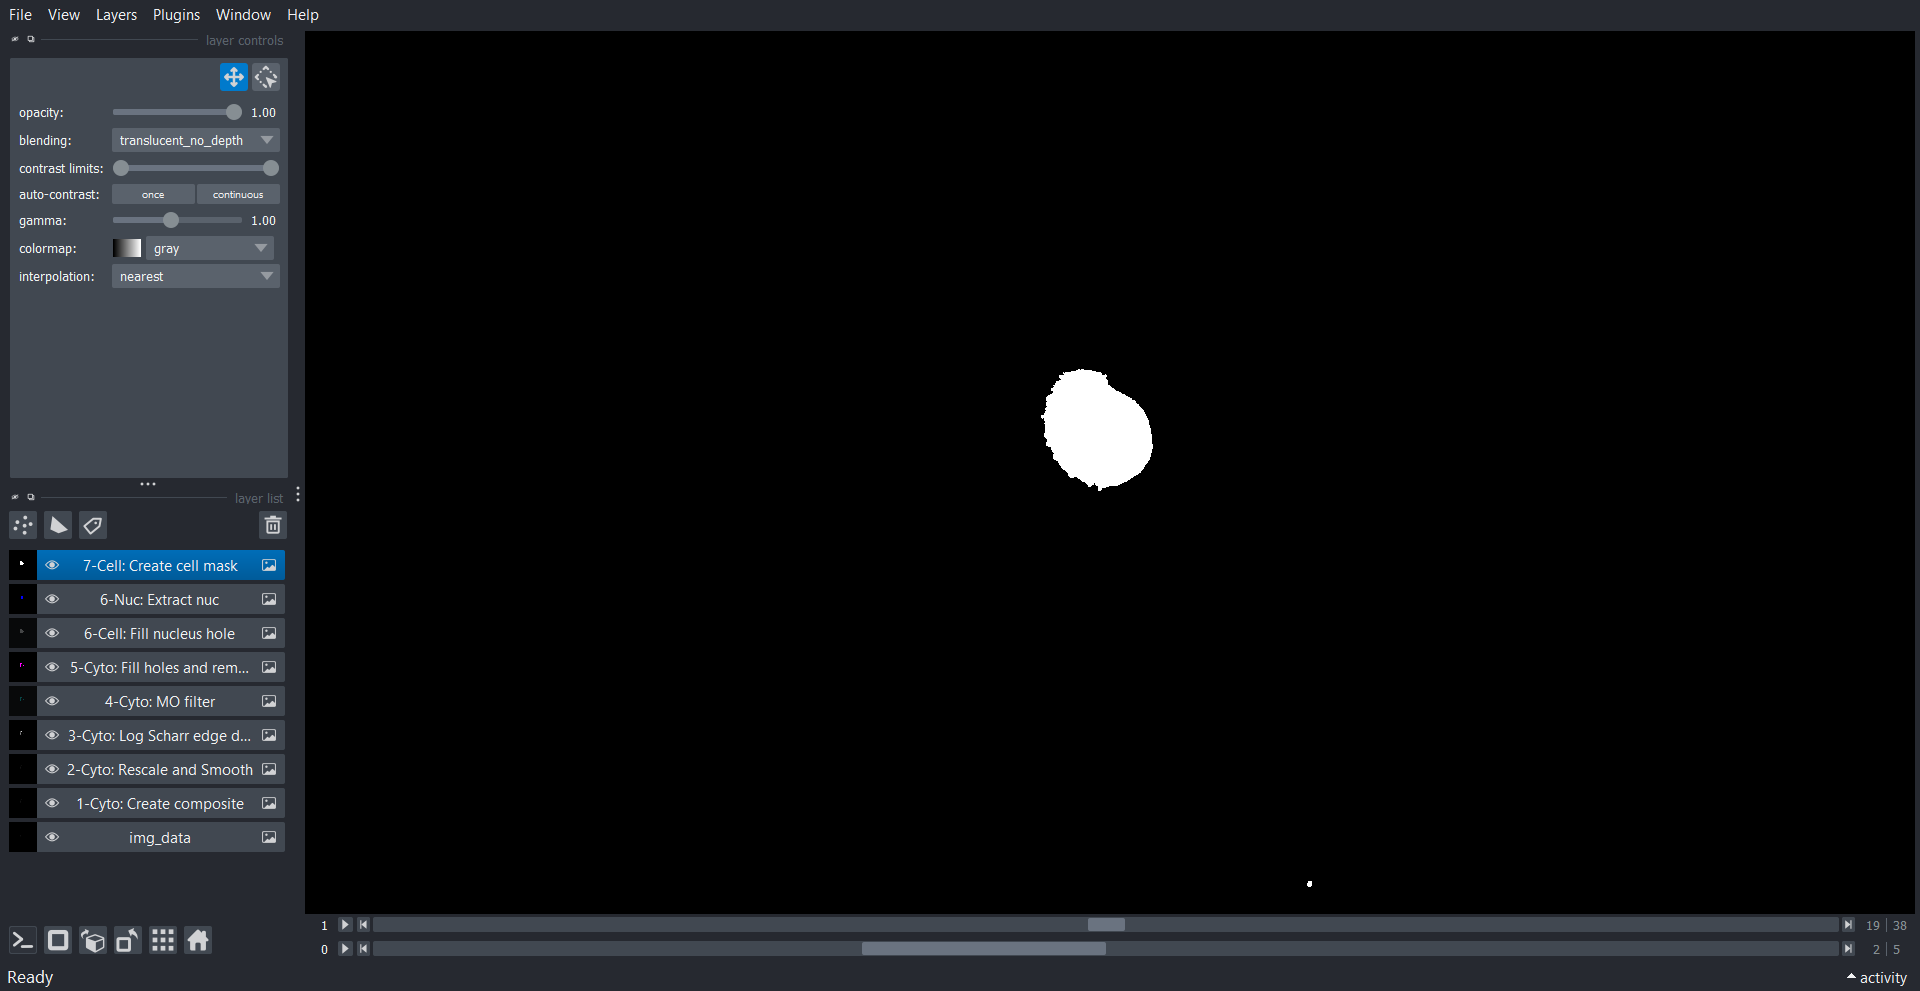

In [20]:
# create cell mask
cell = np.logical_or(cytoplasm_mask, nuclei_labels)

# fill small holes and remove small objects
cleaned_img = fill_and_filter_linear_size(cell, 
                                          hole_min=cell_min_hole_width, 
                                          hole_max=cell_max_hole_width, 
                                          min_size=cell_small_obj_width, 
                                          method=cell_fill_method)
cell_mask = label_bool_as_uint16(cleaned_img)

# adding image to Napari as a new layer
viewer.add_image(cell_mask, scale=scale, name="7-Cell: Create cell mask")

# screenshot viewer
nbscreenshot(viewer, canvas_only = False)

### **`STEP 8` - Stack masks**

#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block stacks the single nucleus, cell, and cytoplasm masks into one multichannel image.

In [ ]:
stack = stack_masks(nuc_mask=nuclei_labels, cellmask=cell_mask)
print(f"Stack mask file structure: {np.shape(stack)}")
print(f"The dimension of '2' represents the 'nucleus' and 'cell' channels, in that order.")

-----
## **SAVING**

## **`Saving` - Save the segmentation output**

#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block saves the instance segmentation output to the `out_data_path` specified earlier.

In [23]:
out_file_n = export_inferred_organelle(stack, "masks_A", meta_dict, out_data_path)

saved file: 20230727_C2-121_conditioned_well 4_cell 1_untreated_Linear unmixing_0_cmle.ome-masks_A


-----
-----
## **Define functions**
The following code includes an example of how the workflow steps above are combined into functions. The final combined `infer_masks_A` function can be run below to process a single image. It is included in the [batch process notebook](batch_process_segmentations.ipynb) to run the above analysis on multiple cells. 

This function can utilized from infer-subc using:
```python
infer_subc.organelles.masks.infer_masks_A()
```

#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block defines the `infer_cytoplasm_fromcomposite()`, function. It is applied below.

In [24]:
##########################
# infer_cytoplasm_fromcomposite
# alternative workflow "a"
##########################
def _infer_cytoplasm_fromcomposite(in_img: np.ndarray,
                                  weights: list[int],
                                  rescale: bool,
                                  median_sz: int,
                                  gauss_sig: float,
                                  mo_method: str,
                                  mo_adjust: float,
                                  mo_cutoff_size: int,
                                  min_hole_w: int,
                                  max_hole_w: int,
                                  small_obj_w: int,
                                  fill_filter_method: str
                                  ) -> np.ndarray:
    """
    Procedure to infer cellmask from linear unmixed input.

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    weights:
        a list of int that corresond to the weights for each channel in the composite; use 0 if a channel should not be included in the composite image
    rescale:
        True = rescale composite
        False = don't rescale composite
    nuclei_labels: 
        a 3d image containing the inferred nuclei labels
    median_sz: 
        width of median filter for _cellmask_ signal
    gauss_sig: 
        sigma for gaussian smoothing of _cellmask_ signal
    mo_method: 
         which method to use for calculating global threshold. Options include:
         "triangle" (or "tri"), "median" (or "med"), and "ave_tri_med" (or "ave").
         "ave" refers the average of "triangle" threshold and "mean" threshold.
    mo_adjust: 
        Masked Object threshold `local_adjust`
    mo_cutoff_size: 
        Masked Object threshold `size_min`
    max_hole_w: 
        hole filling cutoff for cellmask signal post-processing
    small_obj_w: 
        minimum object size cutoff for cellmask signal post-processing
    fill_filter_method:
        determines if fill and filter should be run 'sice-by-slice' or in '3D' 

    Returns
    -------------
    cellmask_mask:
        a logical/labels object defining boundaries of cellmask

    """
    ###################
    # EXTRACT
    ###################
    struct_img = make_aggregate(in_img, *weights, rescale)

    ###################
    # PRE_PROCESSING
    ###################                         
    struct_img = scale_and_smooth(struct_img,
                                   median_size = median_sz, 
                                   gauss_sigma = gauss_sig)
    

    struct_img_non_lin = non_linear_cellmask_transform(struct_img)

    ###################
    # CORE_PROCESSING
    ###################
    struct_obj = masked_object_thresh(struct_img_non_lin, 
                                      global_method=mo_method, 
                                      cutoff_size=mo_cutoff_size, 
                                      local_adjust=mo_adjust)               

    ###################
    # POST_PROCESSING
    ###################
    struct_obj = fill_and_filter_linear_size(struct_obj, 
                                             hole_min=min_hole_w, 
                                             hole_max=max_hole_w, 
                                             min_size= small_obj_w,
                                             method=fill_filter_method)

    ###################
    # POST- POST_PROCESSING
    ###################
    cellmask_out = label_bool_as_uint16(struct_obj)

    return cellmask_out

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block applies the function above to your test image. The settings specified above are applied here.

In [25]:
_CY_object = _infer_cytoplasm_fromcomposite(img_data,
                                            [w0, w1, w2, w3, w4, w5, w6, w7, w8, w9],
                                            cyto_rescale,
                                            cyto_med_filter_size,
                                            cyto_gaussian_smoothing_sigma,
                                            cyto_thresh_method,
                                            cyto_thresh_adj,
                                            cyto_cutoff_size,
                                            cyto_hole_min_width,
                                            cyto_hole_max_width,
                                            cyto_small_object_width,
                                            cyto_fill_filter_method) 

# confirm this output matches the output saved above
print(f"The segmentation output here matches the output created above: {np.all(cytoplasm_mask == _CY_object)}")

The segmentation output here matches the output created above: True


In [26]:
from infer_subc.organelles.cytoplasm import infer_cytoplasm_fromcomposite
CY = infer_cytoplasm_fromcomposite(img_data,
                                    [w0, w1, w2, w3, w4, w5, w6, w7, w8, w9],
                                    cyto_rescale,
                                    cyto_med_filter_size,
                                    cyto_gaussian_smoothing_sigma,
                                    cyto_thresh_method,
                                    cyto_thresh_adj,
                                    cyto_cutoff_size,
                                    cyto_hole_min_width,
                                    cyto_hole_max_width,
                                    cyto_small_object_width,
                                    cyto_fill_filter_method) 

# confirm this output matches the output saved above
print(f"The segmentation output here matches the output created above: {np.all(CY == _CY_object)}")

The segmentation output here matches the output created above: True


#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block defines the `infer_nuclei_fromcytoplasm()`, function. It is applied below.

In [27]:
##########################
#  _infer_nuclei_fromcytoplasm
##########################
def _infer_nuclei_fromcytoplasm(cytoplasm_mask: np.ndarray, 
                                nuc_min_hole_w: int,
                                nuc_max_hole_w: int,
                                nuc_fill_method: str,
                                small_obj_w: int,
                                fill_filter_method: str
                                ) -> np.ndarray:
    """
    Procedure to infer nuclei from linear unmixed input.

    Parameters
    ------------
    cytoplasm_mask: np.ndarray
        a 3d image of the cytoplasm segmentation
    max_hole_w: int
        hole filling cutoff to fill the nuclei
    small_obj_w: int
        object size cutoff to remove artifacts from dilation/erosion steps
    fill_filter_method: str
        to filter artifacts in "3D" or "slice-by-slice"

    Returns
    -------------
    nuclei_object
        mask defined extent of NU
    
    """

    ###################
    # PRE_PROCESSING
    ###################                
    cytoplasm_dilated = binary_dilation(cytoplasm_mask)

    cytoplasm_filled = fill_and_filter_linear_size(cytoplasm_dilated, 
                                                   hole_min=nuc_min_hole_w, 
                                                   hole_max=nuc_max_hole_w, 
                                                   min_size=0, 
                                                   method=nuc_fill_method)

    cytoplasm_eroded = binary_erosion(cytoplasm_filled)

    ###################
    # CORE_PROCESSING
    ###################
    nuclei_xor = np.logical_xor(cytoplasm_mask, cytoplasm_eroded)

    ###################
    # POST_PROCESSING
    ###################
    nuclei_object = fill_and_filter_linear_size(nuclei_xor, 
                                                hole_min=0, 
                                                hole_max=0, 
                                                min_size=small_obj_w,
                                                method=fill_filter_method)

    nuclei_labels = label_uint16(nuclei_object)

    return nuclei_labels

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block applies the function above to your test image. The settings specified above are applied here.

In [28]:
_NU_object = _infer_nuclei_fromcytoplasm(cytoplasm_mask, 
                                         nuc_hole_min_width,
                                         nuc_hole_max_width,
                                         nuc_fill_filter_method, 
                                         nuc_small_object_width,
                                         nuc_fill_filter_method2)

# confirm this output matches the output saved above
print(f"The segmentation output here matches the output created above: {np.all(nuclei_labels == _NU_object)}")

The segmentation output here matches the output created above: True


In [29]:
from infer_subc.organelles.nuclei import infer_nuclei_fromcytoplasm
NU = infer_nuclei_fromcytoplasm(cytoplasm_mask, 
                                         nuc_hole_min_width,
                                         nuc_hole_max_width,
                                         nuc_fill_filter_method, 
                                         nuc_small_object_width,
                                         nuc_fill_filter_method2)

# confirm this output matches the output saved above
print(f"The segmentation output here matches the output created above: {np.all(NU == _NU_object)}")

The segmentation output here matches the output created above: True


#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block defines the `infer_cellmask_fromcytoplasm()`, function. It is applied below.

In [30]:
##########################
#  infer_cellmask_fromcytoplasm
##########################
def _infer_cellmask_fromcytoplasm(cytoplasm_mask: np.ndarray,
                                  nucleus_mask: np.ndarray,
                                  min_hole_width: int,
                                  max_hole_width: int,
                                  small_obj_width: int,
                                  fill_filter_method: str
                                  ) -> np.ndarray:
    """
    Procedure to infer 3D nuclei segmentation from multichannel z-stack input.

    Parameters
    ------------
    cytoplasm_mask: np.ndarray
        3D image containing the mask of the cytoplasm
    nucleus_mask: np.ndarray
        3D image containing the mask of the nucleus
    min_hole_width: int
        minimum size of holes to fill in final cell mask
    max_hole_width: int,
        maximum size of holes to fill in final cell mask
    small_obj_w: int
        minimum object size cutoff to remove from final cell mask; likely not required since small objects were removed from cytoplasm mask
    fill_method: str
        method for fill and filter; either "3D" or "slice_by_slice"

    Returns
    -------------
    cell_mask
        mask defined extent of the entire cell
    
    """

    ###################
    # CORE_PROCESSING
    ###################
    cell = np.logical_or(nucleus_mask, cytoplasm_mask)

    ###################
    # POST_PROCESSING
    ###################
    cleaned_img = fill_and_filter_linear_size(cell, 
                                              hole_min=min_hole_width, 
                                              hole_max=max_hole_width, 
                                              min_size=small_obj_width, 
                                              method=fill_filter_method)

    ###################
    # LABELING
    ###################
    cell_mask = label_bool_as_uint16(cleaned_img)

    return cell_mask

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block applies the function above to your test image. The settings specified above are applied here.

In [31]:
_CM_object = _infer_cellmask_fromcytoplasm(cytoplasm_mask = cytoplasm_mask, 
                                            nucleus_mask = nuclei_labels,
                                            min_hole_width = cell_min_hole_width,
                                            max_hole_width = cell_max_hole_width,
                                            small_obj_width = cell_small_obj_width,
                                            fill_filter_method = cell_fill_method)

# confirm this output matches the output saved above
print(f"The segmentation output here matches the output created above: {np.all(cell_mask == _CM_object)}")

The segmentation output here matches the output created above: True


In [32]:
from infer_subc.organelles.cellmask import infer_cellmask_fromcytoplasm
CM = infer_cellmask_fromcytoplasm(cytoplasm_mask = cytoplasm_mask, 
                                nucleus_mask = nuclei_labels,
                                min_hole_width = cell_min_hole_width,
                                max_hole_width = cell_max_hole_width,
                                small_obj_width = cell_small_obj_width,
                                fill_filter_method = cell_fill_method)

# confirm this output matches the output saved above
print(f"The segmentation output here matches the output created above: {np.all(CM == _CM_object)}")

The segmentation output here matches the output created above: True


#### &#x1F3C3; **Run code; no user input required**
&#x1F453; **FYI:** This code block defines the `infer_masks_A()`, function, the complete function that combines the three above and that will be used for batch processing. It is applied below.

In [33]:
def _infer_masks_A(in_img: np.ndarray,
                    cyto_weights: list[int],
                    cyto_rescale: bool,
                    cyto_median_sz: int,
                    cyto_gauss_sig: float,
                    cyto_mo_method: str,
                    cyto_mo_adjust: float,
                    cyto_mo_cutoff_size: int,
                    cyto_min_hole_w: int,
                    cyto_max_hole_w: int,
                    cyto_small_obj_w: int,
                    cyto_fill_filter_method: str,
                    nuc_min_hole_w: int,
                    nuc_max_hole_w: int,
                    nuc_fill_method: str,
                    nuc_small_obj_w: int,
                    nuc_fill_filter_method: str,
                    cell_min_hole_width: int,
                    cell_max_hole_width: int,
                    cell_small_obj_width: int,
                    cell_fill_filter_method: str
                    ) -> np.ndarray:
    """
    Procedure to infer cellmask from linear unmixed input.

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    cyto_weights:
        a list of int that corresond to the weights for each channel in the composite; use 0 if a channel should not be included in the composite image
    cyto_rescale:
        True = rescale composite
        False = don't rescale composite
    cyto_median_sz: 
        width of median filter for _cellmask_ signal
    cyto_gauss_sig: 
        sigma for gaussian smoothing of _cellmask_ signal
    cyto_mo_method: 
         which method to use for calculating global threshold. Options include:
         "triangle" (or "tri"), "median" (or "med"), and "ave_tri_med" (or "ave").
         "ave" refers the average of "triangle" threshold and "mean" threshold.
    cyto_mo_adjust: 
        Masked Object threshold `local_adjust`
    cyto_mo_cutoff_size: 
        Masked Object threshold `size_min`
    cyto_max_hole_w: 
        hole filling cutoff for cellmask signal post-processing
    cyto_small_obj_w: 
        minimum object size cutoff for cellmask signal post-processing
    cyto_fill_filter_method:
        determines if fill and filter should be run 'sice-by-slice' or in '3D' 
    nuc_max_hole_w: int
        hole filling cutoff to fill the nuclei
    nuc_small_obj_w: int
        object size cutoff to remove artifacts from dilation/erosion steps
    nuc_fill_filter_method: str
        to filter artifacts in "3D" or "slice-by-slice"
    cell_min_hole_width: int
        minimum size of holes to fill in final cell mask
    cell_max_hole_width: int,
        maximum size of holes to fill in final cell mask
    cell_small_obj_w: int
        minimum object size cutoff to remove from final cell mask; likely not required since small objects were removed from cytoplasm mask
    cell_fill_method: str
        method for fill and filter; either "3D" or "slice_by_slice"

    Returns
    -------------
    mask_stack:
        a logical/labels object defining boundaries of nucleus and cellmask

    """
    
    cyto_obj = infer_cytoplasm_fromcomposite(in_img,
                                            cyto_weights,
                                            cyto_rescale,
                                            cyto_median_sz,
                                            cyto_gauss_sig,
                                            cyto_mo_method,
                                            cyto_mo_adjust,
                                            cyto_mo_cutoff_size,
                                            cyto_min_hole_w,
                                            cyto_max_hole_w,
                                            cyto_small_obj_w,
                                            cyto_fill_filter_method) 
    
    nuc_obj = infer_nuclei_fromcytoplasm(cyto_obj, 
                                         nuc_min_hole_w,
                                         nuc_max_hole_w,
                                         nuc_fill_method, 
                                         nuc_small_obj_w,
                                         nuc_fill_filter_method)
    
    cell_obj = infer_cellmask_fromcytoplasm(cytoplasm_mask = cyto_obj, 
                                            nucleus_mask = nuc_obj,
                                            min_hole_width = cell_min_hole_width,
                                            max_hole_width = cell_max_hole_width,
                                            small_obj_width = cell_small_obj_width,
                                            fill_filter_method = cell_fill_filter_method)
    
    stack = stack_masks(nuc_mask=nuc_obj, cellmask=cell_obj)

    return stack

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block applies the function above to your test image. The settings specified above are applied here.

In [34]:
_masks_stack =  _infer_masks_A(in_img = img_data,
                              cyto_weights = [w0, w1, w2, w3, w4, w5, w6, w7, w8, w9],
                              cyto_rescale = cyto_rescale,
                              cyto_median_sz = cyto_med_filter_size,
                              cyto_gauss_sig = cyto_gaussian_smoothing_sigma,
                              cyto_mo_method = cyto_thresh_method,
                              cyto_mo_adjust = cyto_thresh_adj,
                              cyto_mo_cutoff_size = cyto_cutoff_size,
                              cyto_min_hole_w = cyto_hole_min_width,
                              cyto_max_hole_w = cyto_hole_max_width,
                              cyto_small_obj_w = cyto_small_object_width,
                              cyto_fill_filter_method = cyto_fill_filter_method,
                              nuc_min_hole_w = nuc_hole_min_width,
                              nuc_max_hole_w = nuc_hole_max_width,
                              nuc_fill_method = nuc_fill_filter_method,
                              nuc_small_obj_w = nuc_small_object_width,
                              nuc_fill_filter_method = nuc_fill_filter_method2,
                              cell_min_hole_width = cell_min_hole_width,
                              cell_max_hole_width = cell_max_hole_width,
                              cell_small_obj_width = cell_small_obj_width,
                              cell_fill_filter_method = cell_fill_method)

# confirm this output matches the output saved above
print(f"The segmentation output here matches the output created above: {np.all(stack == _masks_stack)}")

The segmentation output here matches the output created above: True


In [35]:
from infer_subc.organelles.masks import infer_masks_A
MS =  infer_masks_A(in_img = img_data,
                              cyto_weights = [w0, w1, w2, w3, w4, w5, w6, w7, w8, w9],
                              cyto_rescale = cyto_rescale,
                              cyto_median_sz = cyto_med_filter_size,
                              cyto_gauss_sig = cyto_gaussian_smoothing_sigma,
                              cyto_mo_method = cyto_thresh_method,
                              cyto_mo_adjust = cyto_thresh_adj,
                              cyto_mo_cutoff_size = cyto_cutoff_size,
                              cyto_min_hole_w = cyto_hole_min_width,
                              cyto_max_hole_w = cyto_hole_max_width,
                              cyto_small_obj_w = cyto_small_object_width,
                              cyto_fill_filter_method = cyto_fill_filter_method,
                              nuc_min_hole_w = nuc_hole_min_width,
                              nuc_max_hole_w = nuc_hole_max_width,
                              nuc_fill_method = nuc_fill_filter_method,
                              nuc_small_obj_w = nuc_small_object_width,
                              nuc_fill_filter_method = nuc_fill_filter_method2,
                              cell_min_hole_width = cell_min_hole_width,
                              cell_max_hole_width = cell_max_hole_width,
                              cell_small_obj_width = cell_small_obj_width,
                              cell_fill_filter_method = cell_fill_method)

# confirm this output matches the output saved above
print(f"The segmentation output here matches the output created above: {np.all(MS == _masks_stack)}")

The segmentation output here matches the output created above: True


-------------
### ✅ **INFER MASKS COMPLETE!**

Now that a single cell has been identified for analysis, the organelle segmentions need to be completed. Continue on to complete the organelle notebooks (1.2 through 1.7) associated to each of the organelles you would like to include in your analysis:
- Infer [`lysosomes`](1.2_infer_lysosome.ipynb)
- Infer [`mitochondria`](1.3_infer_mitochondria.ipynb)
- Infer [`golgi`](1.4_infer_golgi.ipynb)
- Infer [`peroxisomes`](1.5_infer_peroxisome.ipynb)
- Infer [`endoplasmic reticulum (ER)`](1.6_infer_ER.ipynb)
- Infer [`lipid droplets`](1.7_infer_lipid_droplet.ipynb)